In [1]:
!pip uninstall -y pandas_datareader
!pip install git+https://github.com/pydata/pandas-datareader.git

Found existing installation: pandas-datareader 0.10.0
Uninstalling pandas-datareader-0.10.0:
  Successfully uninstalled pandas-datareader-0.10.0
  Cloning https://github.com/pydata/pandas-datareader.git to /tmp/pip-req-build-mdzqwabs
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/pandas-datareader.git /tmp/pip-req-build-mdzqwabs
  Resolved https://github.com/pydata/pandas-datareader.git to commit 4ff62149bb24f72d62874477b6688ddb0fd1f97c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandas-datareader: filename=pandas_datareader-0.11.0.dev76+g4ff6214-py3-none-any.whl size=114770 sha256=219a760c7aaac290349901a7221ddfddb1e057092abb620f7123df32158e5a42
  Stored in directory: /tmp/pip-ephem-wheel-cache-r_nco9dw/wheels/68/09/2b/66ff2e878a27988531be41d35ba4495de3d8f800ebb5de1c07
Successfully built pandas-datareader


In [2]:
### Data Collection
import pandas_datareader as pdr
key = "befddc24ed385cb0467033fd07588c9bfef21fca"

In [3]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

In [4]:
df.to_csv('AAPL.csv')

## 1. Imports & Data Loading

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from statsmodels.tsa.arima.model import ARIMA

# Load dataset (choose one option)
# Option 1: Load from CSV
df = pd.read_csv("AAPL.csv")

# Option 2: Uncomment to fetch directly from Tiingo if API key available
# import pandas_datareader as pdr
# key = "YOUR_TIINGO_API_KEY"
# df = pdr.get_data_tiingo('AAPL', api_key=key)

df.head()


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2020-10-05 00:00:00+00:00,116.50,116.65,113.5500,113.91,106243839,113.332824,113.478746,110.463023,110.813236,106243839,0.0,1.0
1,AAPL,2020-10-06 00:00:00+00:00,113.16,116.12,112.2500,115.70,161498212,110.083625,112.963155,109.198365,112.554573,161498212,0.0,1.0
2,AAPL,2020-10-07 00:00:00+00:00,115.08,115.55,114.1300,114.62,96848985,111.951428,112.408651,111.027255,111.503934,96848985,0.0,1.0
3,AAPL,2020-10-08 00:00:00+00:00,114.97,116.40,114.5901,116.25,83477153,111.844419,113.235543,111.474847,113.089620,83477153,0.0,1.0
4,AAPL,2020-10-09 00:00:00+00:00,116.97,117.00,114.9200,115.28,100506865,113.790047,113.819231,111.795778,112.145991,100506865,0.0,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1255 non-null   object 
 1   date         1255 non-null   object 
 2   close        1255 non-null   float64
 3   high         1255 non-null   float64
 4   low          1255 non-null   float64
 5   open         1255 non-null   float64
 6   volume       1255 non-null   int64  
 7   adjClose     1255 non-null   float64
 8   adjHigh      1255 non-null   float64
 9   adjLow       1255 non-null   float64
 10  adjOpen      1255 non-null   float64
 11  adjVolume    1255 non-null   int64  
 12  divCash      1255 non-null   float64
 13  splitFactor  1255 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.4+ KB


## 2. Preprocessing & Scaling

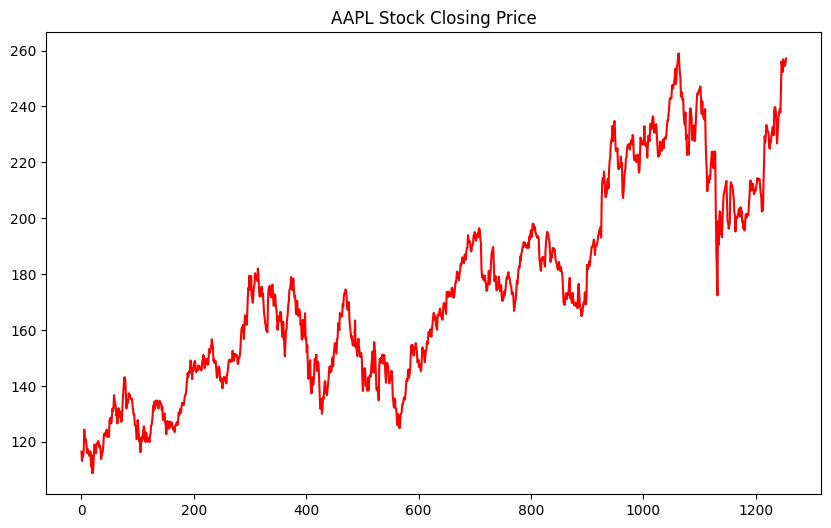

In [7]:

# Use only closing price
df1 = df.reset_index()['close']

# Plot raw data
plt.figure(figsize=(10,6))
plt.plot(df1, color='red')
plt.title("AAPL Stock Closing Price")
plt.show()

# Scaling
scaler = MinMaxScaler(feature_range=(0,1))
df1_scaled = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Train-test split
training_size = int(len(df1_scaled)*0.65)
test_size = len(df1_scaled)-training_size
train_data, test_data = df1_scaled[0:training_size,:], df1_scaled[training_size:len(df1_scaled),:1]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## 3. LSTM Model Training

In [8]:

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, validation_data=(X_test,ytest), epochs=100, batch_size=64, verbose=1)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - loss: 0.0790 - val_loss: 0.0192
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.0069 - val_loss: 0.0283
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0053 - val_loss: 0.0380
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.0040 - val_loss: 0.0100
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0022 - val_loss: 0.0050
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 

## 4. ARIMA Model Training

In [9]:

# Fit ARIMA on training data (non-scaled for ARIMA)
train_arima = df1[:training_size]
test_arima = df1[training_size:]

# Simple ARIMA model
arima_model = ARIMA(train_arima, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test_arima))


## 5. Evaluation & Comparison

In [10]:

# Rescale y_train, ytest for metric comparison
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(ytest.reshape(-1,1))

# LSTM metrics
lstm_rmse = math.sqrt(mean_squared_error(y_test_rescaled, test_predict))
lstm_mape = mean_absolute_percentage_error(y_test_rescaled, test_predict)

# ARIMA metrics
arima_rmse = math.sqrt(mean_squared_error(test_arima, arima_forecast))
arima_mape = mean_absolute_percentage_error(test_arima, arima_forecast)

comparison = pd.DataFrame({
    "Model": ["LSTM", "ARIMA"],
    "RMSE": [lstm_rmse, arima_rmse],
    "MAPE": [lstm_mape, arima_mape]
})

comparison


,Model,RMSE,MAPE
0,LSTM,5.381267,0.018823
1,ARIMA,30.876323,0.118454


## 6. Rolling Window Evaluation (Simplified)

In [11]:

# Simple rolling evaluation for ARIMA (due to speed)
rolling_rmse = []
window_size = 200

for i in range(0, len(df1)-window_size, 50):
    train = df1[i:i+window_size]
    test = df1[i+window_size:i+window_size+10]
    try:
        model_ar = ARIMA(train, order=(5,1,0))
        res = model_ar.fit()
        forecast = res.forecast(steps=len(test))
        rmse = math.sqrt(mean_squared_error(test, forecast))
        rolling_rmse.append(rmse)
    except:
        continue

print("Average Rolling Window RMSE (ARIMA):", np.mean(rolling_rmse))


Average Rolling Window RMSE (ARIMA): 5.667014871452252


## 7. Plots & Discussion

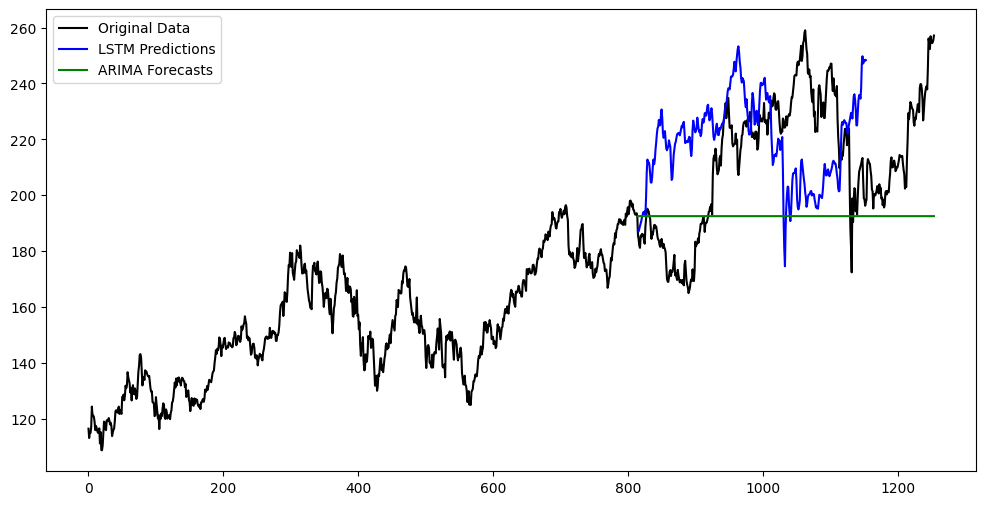

In [12]:

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(df1, label='Original Data', color='black')
plt.plot(range(training_size, training_size+len(test_predict)), test_predict, label='LSTM Predictions', color='blue')
plt.plot(range(training_size, training_size+len(arima_forecast)), arima_forecast, label='ARIMA Forecasts', color='green')
plt.legend()
plt.show()


In [13]:
from tensorflow.keras.models import save_model

# Save trained LSTM model
model.save("lstm_stock_forecast.h5")


In [14]:
from google.colab import files
files.download("lstm_stock_forecast.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>